In [110]:
import math
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nmf.nmf as nmf

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [111]:
df = pl.read_excel('db.xlsx')
df

#,abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,578,420,600,613,550,750,98.0,18.8,null
2,540,400,600,590,540,690,null,null,null
3,540,400,600,590,540,690,null,null,null
4,730,600,900,910,800,1000,null,2.5,null
5,730,600,900,910,800,1000,null,2.5,null
6,730,600,900,910,800,1000,null,4.0,null
7,730,600,900,910,800,1000,null,7.0,null
8,800,400,800,900,700,1000,30.0,1.4,3.2
9,600,400,600,630,600,700,50.0,0.5,1.2


In [112]:
df = df.drop(['#'])
df

abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
i64,i64,i64,i64,i64,i64,f64,f64,f64
578,420,600,613,550,750,98.0,18.8,null
540,400,600,590,540,690,null,null,null
540,400,600,590,540,690,null,null,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,2.5,null
730,600,900,910,800,1000,null,4.0,null
730,600,900,910,800,1000,null,7.0,null
800,400,800,900,700,1000,30.0,1.4,3.2
600,400,600,630,600,700,50.0,0.5,1.2


In [113]:
total, _ = df.shape
for col in df.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 19%
hopt (%): 36%
PCE (%): 47%


In [114]:
X = df.to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 5.80e-02, 8.30e-04],
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 1.70e+00, 1.40e-02],
       [5.75e+02, 4.00e+02, 6.10e+02, ..., 9.50e+01, 1.90e+01, 2.90e+00]])

In [115]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[106, 23, 10, 120, 51, 46, 42, 26, 139, 22, 111, 134, 94, 18, 100, 75, 11, 140, 129, 39, 43, 88, 102, 124, 96, 37, 108, 130, 74, 136, 79, 128, 138, 0]
[31, 140, 88, 66, 51, 30, 40, 139, 16, 14, 78, 15, 68, 67, 126, 46, 7, 93, 106, 19, 131, 13, 53, 69, 37, 11, 124]
[71, 80, 29, 142, 32, 97, 77, 113, 95, 52, 96, 94, 60, 85, 47, 87, 114, 86, 84, 21, 81, 83]


In [116]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 16.  78.  50.  53.  58.  45.  45.  25.  82.  14.  89.  65.  61. 100.
  93.  23.  67.  78.  30. 164.  94.  40.  44.  20.  30.  63.  89.  61.
  30.  70.  70.  50.  96.  98.]
[ 0.29   0.058  8.8   31.3    2.4    4.25  12.23   5.43   0.9    0.5
  1.5    1.     3.3   22.     7.58   1.4    1.4    9.     1.5    5.5
  3.3    0.6    1.2   27.8    3.67   3.4    2.01 ]
[4.40e-01 2.81e+00 2.60e+00 2.90e+00 2.20e+00 8.40e-04 7.90e+00 2.10e+00
 3.00e-02 3.94e+00 6.00e-04 2.00e-01 3.10e+00 1.90e-03 4.06e+00 7.00e-03
 2.10e+00 7.80e-04 1.13e+01 5.50e-01 7.10e+00 1.90e-01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [117]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [118]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k,s)

In [119]:
print(f"{cost} {solution}")

113.1970679067789 (8, 53)


In [120]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[20.09837235 19.11702724 32.11972792 88.9644563  18.5476325  19.13056727
 81.12812497 26.52153954 28.70805575 45.80126595 53.07554907 10.41728906
 63.81412985 71.873592   43.00608119 32.47692603 58.20705475 38.57911793
 23.16760599 11.31826616 58.01514344 53.64620133 32.90539979 24.47734987
 48.09369341 55.27645819 53.35330866 47.40150961 69.57413015 57.27963012
 44.66970465 64.73972997 43.31366419 91.73424347]
[ 9.31607961  6.11220767  8.53848923  8.4123451   3.62757438  6.43873654
  7.55587231  2.28964805  6.07920973  2.30163033  2.22157833  5.0174651
  2.52272798  5.74714778  2.53757779  3.44184049  7.54728576  6.52716512
  1.45166382  8.21198435  6.59784893  1.92411874  4.68912522  7.99681524
 11.44143736  8.25032953  4.47039206]
[2.64379541 0.99470483 2.72528206 1.22767343 3.03175617 1.43875088
 3.09988055 1.9995359  2.17905823 3.35257845 1.82509402 1.77645113
 3.23383947 2.24905051 2.73998968 2.27664157 1.48843236 3.45425549
 1.29836856 2.26527321 3.31697478 2.0120231 ]


In [121]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 39.85206587377582 (54.220689655172414 ± 29.73418013818261)
RMSE(HOPT): 7.648126511849703 (6.698021739130434 ± 9.9950685688083)
RMSE(PCE): 2.9574264641255414 (2.420651973684211 ± 2.970025846705724)


In [122]:
# Get the complete X matrix again
X = df.to_numpy()
X[np.isnan(X)] = 0

# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k,s)

In [123]:
print(f"{cost} {solution}")

124.24185201619163 (8, 89)


In [124]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
print(f'{Xr}')
Xr.dtype = np.dtype([(col, np.dtype(np.float64)) for col in df.columns])
df = pl.DataFrame({field_name: Xr[field_name][:,0] for field_name in Xr.dtype.fields})
df

[[577.97657865 419.76322696 599.9509689  ...  96.73980581  12.12262586
    2.61110776]
 [539.94228626 399.84651737 600.10478074 ...  89.27132657  11.4086123
    2.08701394]
 [540.03927633 399.96188661 599.92901771 ...  32.43648273   5.85402297
    2.41705863]
 ...
 [507.67406902 249.75118524 521.07437117 ...  71.02823892   8.7851165
    2.11459948]
 [507.85271974 249.79035432 520.93773497 ...  71.11390505   8.80473635
    2.10417441]
 [574.95808353 399.85399882 610.07069678 ...  94.61543642  12.02494955
    1.99627548]]


abs_peak,abs_min,abs_max,em_peak,em_min,em_max,QY (%),hopt (%),PCE (%)
f64,f64,f64,f64,f64,f64,f64,f64,f64
577.976579,419.763227,599.950969,613.282328,550.087773,750.14486,96.739806,12.122626,2.611108
539.942286,399.846517,600.104781,590.087793,539.812463,690.008278,89.271327,11.408612,2.087014
540.039276,399.961887,599.929018,590.026364,540.053916,689.896872,32.436483,5.854023,2.417059
729.892938,600.158877,900.090214,910.279726,800.193423,999.984331,57.760219,9.274447,3.127978
729.712679,600.304479,899.995517,910.519227,800.309606,999.86869,26.262601,5.972709,3.510284
729.847286,600.169053,900.146306,910.301876,800.159302,999.96009,78.084204,10.984854,3.259567
729.902684,600.151143,900.127632,910.281548,800.152083,999.996592,76.398968,10.987981,3.11787
801.270828,400.56593,799.273514,900.471815,699.863844,999.340389,33.548028,5.819138,3.188354
600.458223,399.929179,599.727105,629.871476,599.929917,699.826882,51.456616,8.202646,1.637378


## Regression

In [125]:
# Get Output variables
PCE = df[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

hopt = df[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df.drop(['hopt (%)', 'PCE (%)'])
X = df.to_numpy()

In [126]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

models = [('Linear Regression', LinearRegression()),
          ('K Neighbors Regressor', KNeighborsRegressor()),
          ('Lasso Regression', Lasso()),
          ('Support Vector Regressor', SVR()),
          ('ANN', MLPRegressor(max_iter=3000)),
          ('Random Forest Regressor', RandomForestRegressor()),
          ('Gradient Boosting Regressor', GradientBoostingRegressor())]

## PCE
print(f'PCE')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_PCE, cv=5, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()
    
## HOPT
print(f'HOPT')
for m in models:
    scores = -1 * cross_val_score(m[1], X, y_hopt, cv=5, scoring='neg_mean_absolute_error')
    print(f'{m[0]:30}: {scores.mean()}')
print()

PCE
Linear Regression             : 1.3521313242567819e-14
K Neighbors Regressor         : 0.3327869807487055
Lasso Regression              : 0.17572407680184857
Support Vector Regressor      : 0.2492075044272482
ANN                           : 8.943839901087896
Random Forest Regressor       : 0.03286744748506269
Gradient Boosting Regressor   : 0.026238849208629615

HOPT
Linear Regression             : 1.6613803928648088e-14
K Neighbors Regressor         : 1.8812734013324157
Lasso Regression              : 0.18032847370534918
Support Vector Regressor      : 1.9973030042241144
ANN                           : 0.8327340166298987
Random Forest Regressor       : 0.12331086861763978
Gradient Boosting Regressor   : 0.09174651659533056



## Clustering

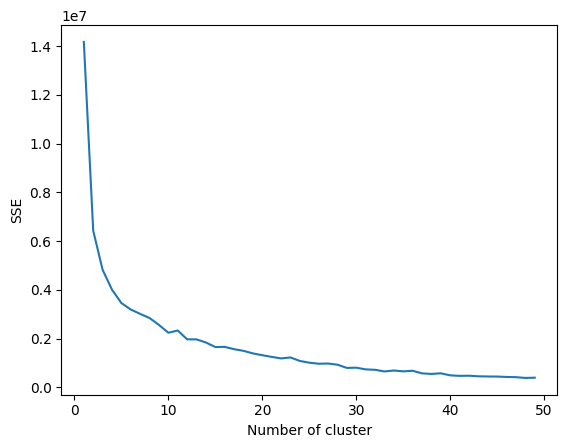

In [127]:
df_input = df.drop(['hopt (%)', 'PCE (%)'])
X = df.to_numpy()
sse = {}

for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    #df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

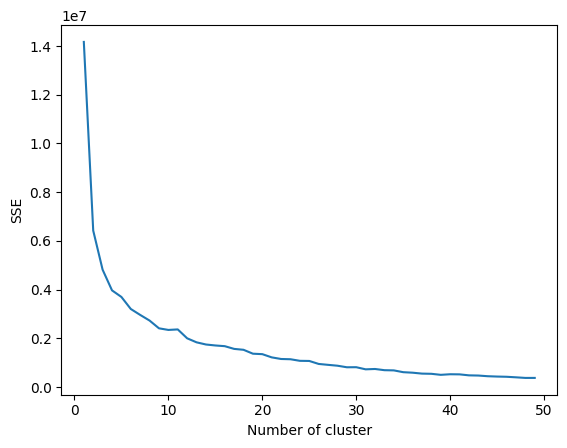

In [128]:
X = df.to_numpy()
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    #df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()